Initialising Git for version control

In [60]:
%cd /content/drive/MyDrive/AI_project

!git init
!git config --global user.email "payelsardar.96@gmail.com"
!git config --global user.name "PSardar19"

!git checkout -b classifier

/content/drive/MyDrive/AI_project
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/drive/MyDrive/AI_project/.git/
Switched to a new branch 'classifier'


In [58]:
!git remote add origin https://github.com/PSardar19/retinal-disease-classifier.git

error: remote origin already exists.


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import warnings
import numpy as np
from numpy import where
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
from PIL import ImageEnhance
import cv2

from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import NearMiss

from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay,f1_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector as selector

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam

In [30]:
import zipfile

# Unzipping the images
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/AI_project/images.zip", 'r')
zip_ref.extractall("/content/drive/MyDrive/AI_project/")
zip_ref.close()

In [31]:
import os

# The path to the images folder on google drive
path = '/content/drive/MyDrive/AI_project/eye-images'

normal = os.path.join(path,'1_normal/')
cataract = os.path.join(path,'2_cataract/')
glaucoma = os.path.join(path,'2_glaucoma/')
print("Number of Normal eye dataset", len(os.listdir(normal)))
print("Number of Cataract dataset", len(os.listdir(cataract)))
print("Number of Glaucoma dataset", len(os.listdir(glaucoma)))


Number of Normal eye dataset 300
Number of Cataract dataset 100
Number of Glaucoma dataset 101


In [32]:
## Load the file names from all directories
normal_images = os.listdir(normal)
cataract_images =  os.listdir(cataract)
glaucoma_images =  os.listdir(glaucoma)

In [38]:
import math

def display_images(directory, image_list, num_images, title="Images", images_per_row=5):
    """
    Displays a specified number of images from a given directory in rows for better viewing.

    Parameters:
    - directory (str): Path to the directory containing images.
    - image_list (list): List of image file names in the directory.
    - num_images (int): Number of images to display.
    - title (str): Title for the displayed images (default: "Images").
    - images_per_row (int): Number of images to display per row (default: 5).

    Returns:
    - None
    """
    # Validate the number of images
    if num_images > len(image_list):
        raise ValueError(f"Requested {num_images} images, but only {len(image_list)} are available.")

    # Calculate the number of rows needed
    num_rows = math.ceil(num_images / images_per_row)

    # Plot the images
    plt.figure(figsize=(images_per_row * 3, num_rows * 3))  # Adjust the figure size dynamically
    for i, image_name in enumerate(image_list[:num_images]):
        img_path = os.path.join(directory, image_name)
        img = Image.open(img_path)

        # Determine subplot position
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(img)
        plt.title(f"{title} {i + 1}", fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

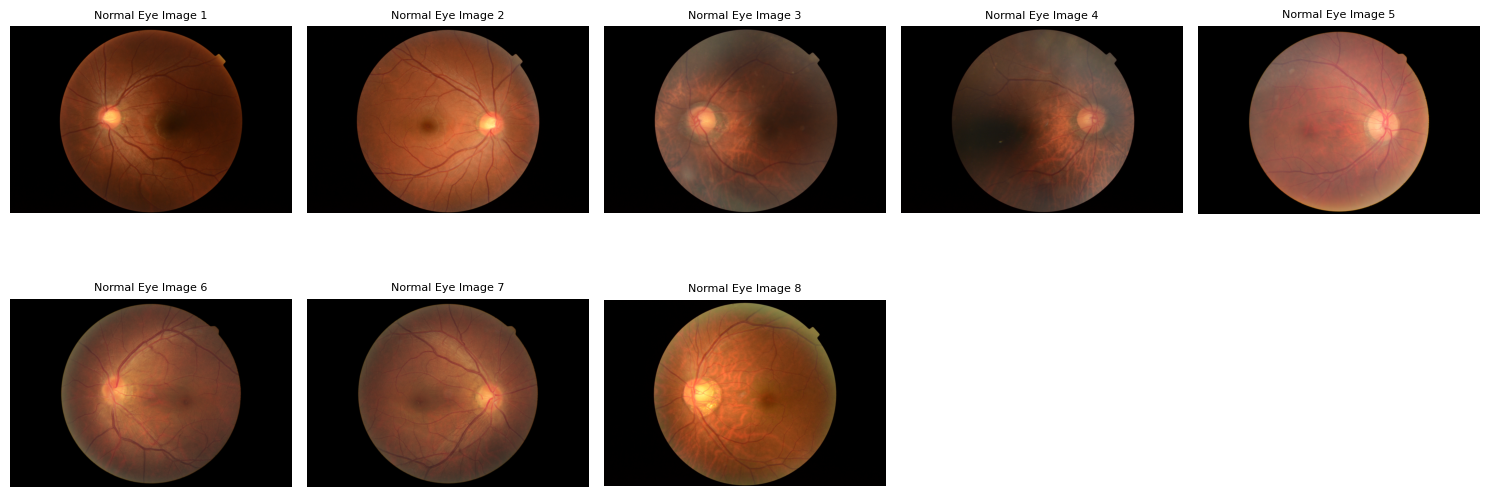

In [41]:
display_images(normal,
               normal_images,
               num_images=8,
               title="Normal Eye Image")

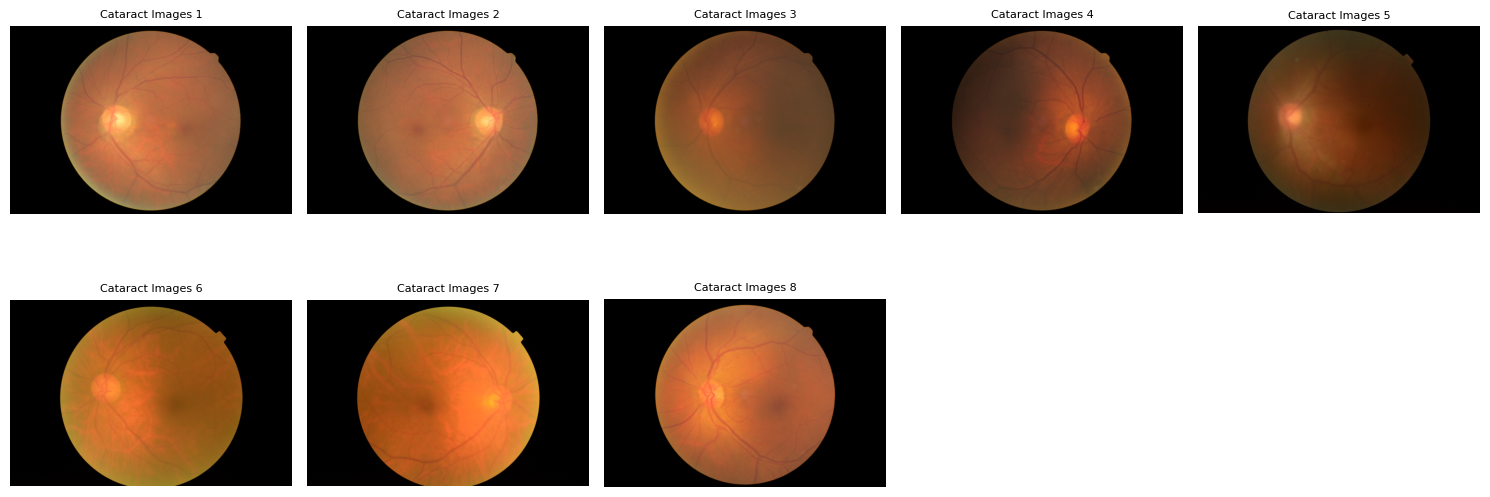

In [40]:
display_images(cataract,
               cataract_images,
               num_images=8,
               title="Cataract Image")

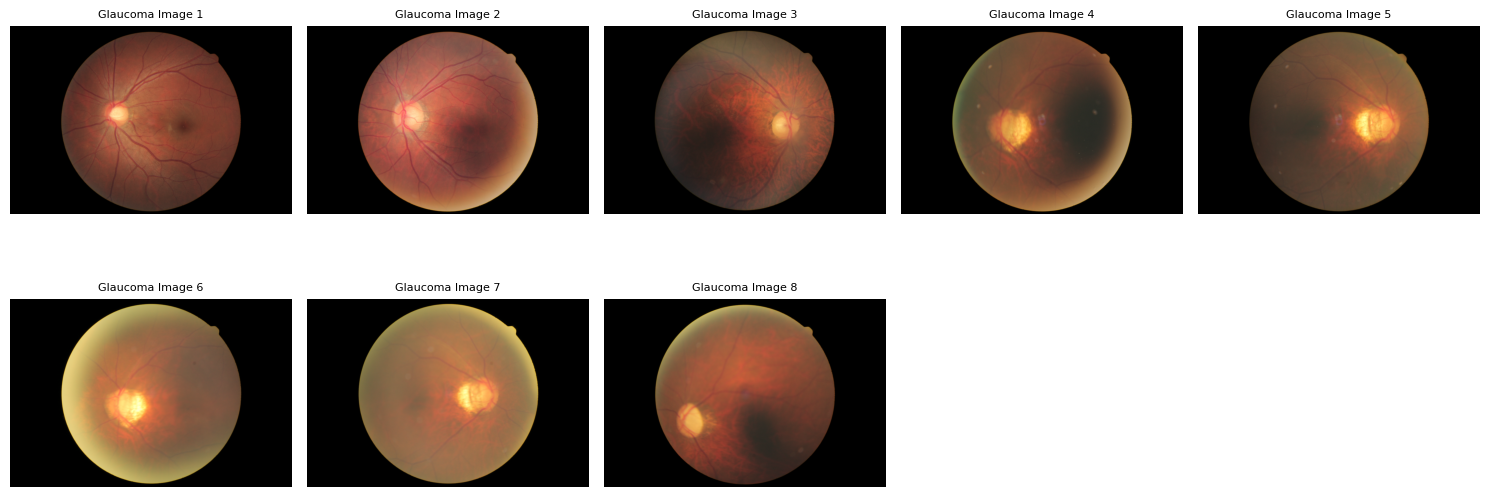

In [42]:
display_images(glaucoma,
               glaucoma_images,
               num_images=8,
               title="Glaucoma Image")

Quality Control of the Datasets

The following code chunk verifies the image integrity using the the Pillow package and provides flexibility to choose between sequential and parallel processing. Sequential processing is simple and suitable for small datasets, while parallel processing accelerates the validation of large datasets by utilizing multiple threads. Users can toggle between these options using a parameter, optimizing the process based on dataset size and system resources.

In [54]:
from concurrent.futures import ThreadPoolExecutor

# This function accepts the path to a single file and checks if its corrupt or not
def is_image_corrupt(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify the integrity of the image
        return None  # return None if image is valid
    except Exception:
        return file_path  # If corrupt, return file path

# This function allows the validation of images in a folder by sequential or parallel processing methods
def find_corrupt_images(image_dir, use_parallel=True, max_workers=4):

    # Collect all image files in the directory
    image_files = [
        os.path.join(image_dir, file)
        for file in os.listdir(image_dir)
        if file.lower().endswith(('.png', '.jpeg'))
    ]

    if use_parallel:
        # Parallel processing using ThreadPoolExecutor
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            corrupt_files = list(filter(None, executor.map(is_image_corrupt, image_files)))
    else:
        # Sequential processing
        corrupt_files = [file for file in image_files if is_image_corrupt(file)]

    return corrupt_files

# To remove corrupt files from the ML pipeline, if any
def remove_corrupt_images(image_dir, corrupt_files):
    for corrupt_file in corrupt_files:
        os.remove(corrupt_file)  # Remove the corrupt file
        print(f"Removed corrupted file: {corrupt_file}")

Checking for corrupted files in the image folders

In [55]:
folders = [normal, cataract, glaucoma]

for folder in folders:
    folder_name = os.path.basename(os.path.normpath(folder))
    print(f"Checking for corrupted files in {folder_name}...")

    # Using sequential image validation as the dataset is small.
    corrupt_files = find_corrupt_images(folder, use_parallel=False)

    if corrupt_files:
        print(f"Corrupted files in {folder_name}:")
        print("\n".join(corrupt_files))
        remove_corrupt_images(folder, corrupt_files)
    else:
        print(f"No corrupted files found in {folder_name}.")
    print("-" * 50)


Checking for corrupted files in 1_normal...
No corrupted files found in 1_normal.
--------------------------------------------------
Checking for corrupted files in 2_cataract...
No corrupted files found in 2_cataract.
--------------------------------------------------
Checking for corrupted files in 2_glaucoma...
No corrupted files found in 2_glaucoma.
--------------------------------------------------


In [59]:
!git add Eye_Disease_classification.ipynb
!git commit -m "Loading dataset, Exploring images, Quality Control of Raw images"

fatal: pathspec 'Eye_Disease_classification.ipynb' did not match any files
On branch classifier

Initial commit

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.config/
	drive/
	sample_data/

nothing added to commit but untracked files present (use "git add" to track)
